In [ ]:
# Download yolov8n-pose backbone (cached by Ultralytics)
from pathlib import Path
from ultralytics import YOLO

target = Path('yolov8n-pose.pt')
if target.exists():
    print('yolov8n-pose.pt already exists at', target)
else:
    print('Downloading yolov8n-pose.pt (this will be cached by Ultralytics) ...')
    # Loading via YOLO(...) will download and cache the weights if not present
    _ = YOLO('yolov8n-pose.pt')
    print('Download triggered. The file will be available from Ultralytics cache; if you need a local copy, you can export or copy it from the cache.')


In [ ]:
# Train (local-friendly version)
import os, yaml
from pathlib import Path
import torch
from ultralytics import YOLO

# Detect Kaggle vs local
IS_KAGGLE = bool(os.environ.get('KAGGLE_URL_BASE')) or Path('/kaggle/working').exists()
print('Environment:', 'Kaggle' if IS_KAGGLE else 'Local')

# Dataset preference order:
# 1. merged_dataset/data_merged.yaml (nếu đã merge)
# 2. dataset4corner/dataset.yaml
# 3. dataset/data.yaml
candidates = [
    Path('merged_dataset/data_merged.yaml'),
    Path('dataset4corner/dataset.yaml'),
    Path('dataset/data.yaml'),
]
source_yaml = next((p for p in candidates if p.exists()), None)
assert source_yaml is not None, 'Không tìm thấy bất kỳ YAML dataset nào (merged_dataset/data_merged.yaml | dataset4corner/dataset.yaml | dataset/data.yaml)'
print('Using source dataset YAML ->', source_yaml)

with open(source_yaml, 'r') as f:
    data = yaml.safe_load(f) or {}

# --- PATH NORMALIZATION + FALLBACKS ---
# Một số YAML (vd dataset4corner/dataset.yaml) có thể chứa đường dẫn tuyệt đối từ máy khác -> gây lỗi.
raw_path = data.get('path')
print('Raw path from YAML:', raw_path)

# Ưu tiên: nếu người dùng set FORCE_DATASET_PATH thì dùng luôn
force_path = os.environ.get('FORCE_DATASET_PATH')
if force_path:
    print('FORCE_DATASET_PATH override ->', force_path)
    data['path'] = force_path

# Nếu không có override, xử lý logic mặc định
if not force_path:
    # base ứng viên lấy từ YAML nếu có, ngược lại folder chứa YAML
    base_candidate = Path(raw_path) if raw_path else source_yaml.parent

    # Nếu base_candidate là absolute nhưng không tồn tại -> fallback
    if raw_path and not base_candidate.exists():
        print('[WARN] Absolute path trong YAML không tồn tại -> fallback source folder')
        base_candidate = source_yaml.parent

    # Nếu thư mục ảnh train không tồn tại trong base_candidate -> thử các fallback khác
    expected_train = base_candidate / 'images' / 'train'
    expected_val   = base_candidate / 'images' / 'val'
    if not expected_train.exists() or not expected_val.exists():
        print('[WARN] images/train hoặc images/val không tồn tại dưới base_candidate:', base_candidate)
        # Thử fallback 1: chính thư mục bên cạnh YAML (source_yaml.parent)
        alt1 = source_yaml.parent
        if (alt1 / 'images' / 'train').exists():
            print(' -> Fallback thành công: dùng', alt1)
            base_candidate = alt1
        else:
            # Thử fallback 2: không đặt path (YOLO sẽ đọc đường dẫn tương đối)
            print(' -> Fallback alt1 thất bại. Xoá khóa path để YOLO dùng relative paths.')
            data.pop('path', None)
            base_candidate = None

    if base_candidate is not None:
        data['path'] = str(base_candidate.resolve())

# Nếu vẫn chưa có path key, bảo đảm train/val là relative
if 'path' not in data:
    print('[INFO] Sử dụng relative paths (không có khóa path trong YAML output).')

# Chuẩn hoá train/val key (nếu YAML cũ dùng image/train ... vẫn giữ nguyên)
train_key = data.get('train', 'images/train')
val_key   = data.get('val', 'images/val')

# Loại bỏ test nếu không rõ
if not data.get('test'):
    data.pop('test', None)

# Đảm bảo các khóa pose
data.setdefault('names', ['plate'])
data.setdefault('kpt_shape', [4, 3])
data.setdefault('skeleton', [[0,1],[1,2],[2,3],[3,0]])
data.setdefault('flip_idx', [0,1,2,3])

# Ghi lại train/val (phòng trường hợp thay đổi biến)
data['train'] = train_key
data['val']   = val_key

# Đường dẫn YAML xuất ra
if IS_KAGGLE:
    out_yaml = Path('/kaggle/working/data.yaml')
else:
    out_yaml = Path('data_local.yaml')  # local file trong project root

out_yaml.parent.mkdir(parents=True, exist_ok=True)
with open(out_yaml, 'w') as f:
    yaml.safe_dump(data, f, sort_keys=False)
print('Written normalized YAML ->', out_yaml)
print('--- Final YAML content ---')
print(yaml.safe_dump(data, sort_keys=False))

# Sanity check tồn tại thư mục
paths_to_check = []
base_for_check = Path(data['path']) if 'path' in data else source_yaml.parent
paths_to_check.extend([
    base_for_check/'images'/'train',
    base_for_check/'images'/'val',
    base_for_check/'labels'/'train',
    base_for_check/'labels'/'val',
])
for p in paths_to_check:
    print('Exists:', p, p.exists())

missing_crit = [p for p in paths_to_check[:2] if not p.exists()]
if missing_crit:
    raise FileNotFoundError(f"❌ Không tìm thấy thư mục ảnh train/val sau khi chuẩn hoá: {missing_crit}. Hãy kiểm tra lại dataset4corner cấu trúc hoặc chỉnh FORCE_DATASET_PATH.")

# Chọn checkpoint
ckpt_candidates = [
    Path('runs/pose_plate_merged/weights/best.pt'),
    Path('runs/pose_plate/weights/best.pt'),
    Path('best.pt'),
]
ckpt = next((p for p in ckpt_candidates if p.exists()), None)
if ckpt:
    print(f'Loading checkpoint: {ckpt}')
    model = YOLO(str(ckpt))
else:
    print('No existing checkpoint found -> init new small pose model')
    backbone_opts = ['yolo11n-pose.pt','yolov8n-pose.pt']
    backbone = next((b for b in backbone_opts if Path(b).exists()), None)
    model = YOLO(backbone) if backbone else YOLO('yolov8n-pose.pt')  # sẽ tải nếu có mạng

# Tham số train nhanh để TEST local
EPOCHS = int(os.environ.get('TEST_EPOCHS', '5'))  # đổi biến môi trường nếu muốn
BATCH  = int(os.environ.get('TEST_BATCH',  '4'))

train_args = dict(
    data=str(out_yaml),
    imgsz=640,
    epochs=EPOCHS,
    patience=0,              # Không early stop trong test ngắn
    batch=BATCH,
    device=0 if torch.cuda.is_available() else 'cpu',
    workers=2 if IS_KAGGLE else 4,
    project='runs',
    name='pose_plate_local_test',
    exist_ok=True,
    pretrained=False,        # tránh tải online
    cache='ram',
    plots=True,
    save_period=0,
    seed=42,
    amp=False,               # bạn có thể bật True nếu torch + GPU hỗ trợ
    verbose=True,
)
print('Train args:', train_args)

results = model.train(**train_args)
print('Done. Best metrics path in runs/pose_plate_local_test')

In [ ]:
# Gộp 3 dataset: dataset4corner, archive_1, archive_2 vào merged_dataset
import shutil, os
from pathlib import Path
import yaml
from collections import defaultdict
def merge_datasets(sources, dest):
    dest = Path(dest)
    for split in ['images/train', 'images/val', 'labels/train', 'labels/val']:
        (dest/split).mkdir(parents=True, exist_ok=True)
    name_map = defaultdict(int)
    for src in sources:
        src = Path(src)
        for split in ['images/train', 'images/val', 'labels/train', 'labels/val']:
            src_dir = src/split
            if not src_dir.exists(): continue
            for f in src_dir.glob('*'):
                stem = f.stem
                ext = f.suffix
                # Đảm bảo không trùng tên file
                while True:
                    new_name = f"{stem}{'' if name_map[stem]==0 else f'_{name_map[stem]}'}{ext}"
                    out_path = dest/split/new_name
                    if not out_path.exists(): break
                    name_map[stem] += 1
                shutil.copy2(f, out_path)
    print('Đã gộp xong datasets vào', dest)
    # Tạo YAML mới
    yaml_path = dest/'data_merged.yaml'
    yaml_dict = {
        'train': str((dest/'images/train').resolve()),
        'val': str((dest/'images/val').resolve()),
        'nc': 1,
        'names': ['plate'],
        'kpt_shape': [4,3],
        'flip_idx': [[0,1],[2,3]]
    }
    with open(yaml_path, 'w') as f:
        yaml.safe_dump(yaml_dict, f, sort_keys=False)
    print('Đã tạo YAML:', yaml_path)
merge_datasets(['dataset4corner', 'archive_1', 'archive_2'], 'merged_dataset')

In [ ]:
# Tiền xử lý ảnh: grayscale, CLAHE, gamma, edge map cho merged_dataset
import cv2
import numpy as np
from tqdm import tqdm
def preprocess_img(in_path, out_path, alpha=0.6, gamma=1.2):
    img = cv2.imread(str(in_path))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)
    invG = 1.0 / gamma
    lut = np.array([((i / 255.0) ** invG) * 255 for i in np.arange(256)]).astype('uint8')
    gam = cv2.LUT(cl, lut)
    edges = cv2.Canny(gam, 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8))
    edges_col = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    edges_col[:,:,1] = edges
    edges_col[:,:,0] = edges
    blended = cv2.addWeighted(cv2.cvtColor(gam, cv2.COLOR_GRAY2BGR), 1-alpha, edges_col, alpha, 0)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), blended)
def preprocess_dataset(src_root, dst_root):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    for split in ['train', 'val']:
        src_dir = src_root/'images'/split
        dst_dir = dst_root/'images'/split
        dst_dir.mkdir(parents=True, exist_ok=True)
        files = list(src_dir.glob('*'))
        for f in tqdm(files, desc=f'Preprocessing {split} images'):
            out_f = dst_dir/f.name
            preprocess_img(f, out_f)
    # Copy labels giữ nguyên
    for split in ['train', 'val']:
        src_lbl = src_root/'labels'/split
        dst_lbl = dst_root/'labels'/split
        dst_lbl.mkdir(parents=True, exist_ok=True)
        for f in src_lbl.glob('*'):
            shutil.copy2(f, dst_lbl/f.name)
    print('Tiền xử lý xong, ảnh lưu ở', dst_root)
preprocess_dataset('merged_dataset', 'prep_merged_dataset')

In [ ]:
# Tiền xử lý blend edge map vào ảnh gốc/xám (giữ thông tin thật, overlay cạnh)
import cv2
import numpy as np
from tqdm import tqdm
from pathlib import Path
import shutil
def preprocess_img_blend(in_path, out_path, alpha=0.25, gamma=1.2, use_gray=False):
    img = cv2.imread(str(in_path))
    if use_gray:
        base = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)
    else:
        base = img.copy()
    # CLAHE + gamma
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(gray)
    invG = 1.0 / gamma
    lut = np.array([((i / 255.0) ** invG) * 255 for i in np.arange(256)]).astype('uint8')
    gam = cv2.LUT(cl, lut)
    # Edge map
    edges = cv2.Canny(gam, 50, 150)
    edges = cv2.dilate(edges, np.ones((3,3), np.uint8))
    edges_col = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    edges_col[:,:,1] = edges
    edges_col[:,:,0] = edges
    # Blend edge map lên base (ảnh gốc/xám)
    blended = cv2.addWeighted(base, 1-alpha, edges_col, alpha, 0)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(str(out_path), blended)
def preprocess_dataset_blend(src_root, dst_root, alpha=0.25, gamma=1.2, use_gray=False):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    for split in ['train', 'val']:
        src_dir = src_root/'images'/split
        dst_dir = dst_root/'images'/split
        dst_dir.mkdir(parents=True, exist_ok=True)
        files = list(src_dir.glob('*'))
        for f in tqdm(files, desc=f'Preprocessing {split} images (blend edge)'):
            out_f = dst_dir/f.name
            preprocess_img_blend(f, out_f, alpha=alpha, gamma=gamma, use_gray=use_gray)
    # Copy labels giữ nguyên
    for split in ['train', 'val']:
        src_lbl = src_root/'labels'/split
        dst_lbl = dst_root/'labels'/split
        dst_lbl.mkdir(parents=True, exist_ok=True)
        for f in src_lbl.glob('*'):
            shutil.copy2(f, dst_lbl/f.name)
    print('Tiền xử lý xong, ảnh blend cạnh lưu ở', dst_root)
# Ví dụ: blend edge map vào ảnh gốc, alpha=0.25 (có thể tăng lên 0.3-0.4 nếu muốn cạnh nổi hơn)
preprocess_dataset_blend('merged_dataset', 'prep_merged_dataset_blend', alpha=0.25, gamma=1.2, use_gray=False)

In [ ]:
# Kiểm tra nhãn: overlay keypoint từ label lên ảnh, lưu ra check_labels_vis
import cv2
import numpy as np
from pathlib import Path
import random
def draw_kpts(img, kpts, color=(0,255,255)):
    for i, (x, y, v) in enumerate(kpts):
        if v > 0:
            cv2.circle(img, (int(x), int(y)), 5, color, -1)
            cv2.putText(img, str(i), (int(x)+2, int(y)-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
    return img
def check_labels_vis(img_dir, label_dir, out_dir, n_samples=30, img_size=640):
    img_dir = Path(img_dir)
    label_dir = Path(label_dir)
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    img_files = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    random.shuffle(img_files)
    for img_path in img_files[:n_samples]:
        label_path = label_dir / (img_path.stem + '.txt')
        if not label_path.exists(): continue
        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]
        with open(label_path) as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 5+12: continue  # 4 kpts * 3 + 5 bbox fields
                kpts = []
                for i in range(4):
                    x = float(parts[5 + i*3]) * w
                    y = float(parts[5 + i*3 + 1]) * h
                    v = float(parts[5 + i*3 + 2])
                    kpts.append((x, y, v))
                img = draw_kpts(img, kpts)
        cv2.imwrite(str(out_dir / img_path.name), img)
    print(f'Đã lưu {n_samples} ảnh kiểm tra nhãn vào {out_dir}')
# Ví dụ sử dụng: kiểm tra nhãn trên bộ blend
check_labels_vis('prep_merged_dataset_blend/images/val', 'prep_merged_dataset_blend/labels/val', 'check_labels_vis', n_samples=30)

In [ ]:
# Xuất file txt dự đoán YOLOv8-pose ra pred_labels và kiểm tra tự động keypoint giữa label và dự đoán (KHÔNG dùng hàm, chỉ chạy tuần tự các bước, mọi thứ trong 1 cell)
from ultralytics import YOLO
from pathlib import Path
import os
import cv2
import numpy as np

# --- BƯỚC 1: Xuất file txt dự đoán YOLOv8-pose ra pred_labels ---
model_path = 'best.pt'  # Đổi tên file model nếu cần
img_dir = 'prep_merged_dataset_blend/images/val'
out_dir = 'pred_labels'
conf = 0.25
device = 0

Path(out_dir).mkdir(parents=True, exist_ok=True)
model = YOLO(model_path)
img_dir_p = Path(img_dir)
img_files = list(img_dir_p.glob('*.jpg')) + list(img_dir_p.glob('*.png'))
for img_path in img_files:
    results = model(img_path, conf=conf, device=device)
    for r in results:
        if hasattr(r, 'keypoints') and r.keypoints is not None and r.boxes is not None:
            for box, kpts, score in zip(r.boxes.xywhn.cpu().numpy(), r.keypoints.xyn.cpu().numpy(), r.boxes.conf.cpu().numpy()):
                line = [0]  # class 0
                line += list(box)
                for kp in kpts:
                    line += list(kp)
                txt_path = Path(out_dir) / (img_path.stem + '.txt')
                with open(txt_path, 'a') as f:
                    f.write(' '.join(f'{x:.6f}' for x in line) + '\n')
print(f'Đã xuất file txt dự đoán vào {Path(out_dir).resolve()}')

# --- BƯỚC 2: Kiểm tra tự động keypoint giữa label và dự đoán ---
label_dir = 'prep_merged_dataset_blend/labels/val'
pred_dir = out_dir
out_dir_check = 'check_kpt_error'
error_thresh = 10

Path(out_dir_check).mkdir(parents=True, exist_ok=True)
img_files = list(img_dir_p.glob('*.jpg')) + list(img_dir_p.glob('*.png'))
n_checked = 0
n_error = 0
for img_path in img_files:
    label_path = Path(label_dir) / (img_path.stem + '.txt')
    pred_path = Path(pred_dir) / (img_path.stem + '.txt')
    if not label_path.exists() or not pred_path.exists(): continue
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    # Parse label kpts
    kpts_gt = []
    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5+12: continue
            for i in range(4):
                x = float(parts[5 + i*3]) * w
                y = float(parts[5 + i*3 + 1]) * h
                v = float(parts[5 + i*3 + 2])
                kpts_gt.append((x, y, v))
    # Parse pred kpts
    kpts_pred = []
    with open(pred_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5+12: continue
            for i in range(4):
                x = float(parts[5 + i*3]) * w
                y = float(parts[5 + i*3 + 1]) * h
                v = float(parts[5 + i*3 + 2])
                kpts_pred.append((x, y, v))
    # Tính sai số
    if len(kpts_gt) != 4 or len(kpts_pred) != 4:
        continue
    errors = [np.linalg.norm(np.array(kpts_gt[i][:2]) - np.array(kpts_pred[i][:2])) for i in range(4)]
    n_checked += 1
    if any(e > error_thresh for e in errors):
        n_error += 1
        # Vẽ GT: xanh, Pred: đỏ
        img_vis = img.copy()
        for i, (x, y, v) in enumerate(kpts_gt):
            if v > 0:
                cv2.circle(img_vis, (int(x), int(y)), 5, (0,255,0), -1)
                cv2.putText(img_vis, f'GT{i}', (int(x)+2, int(y)-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        for i, (x, y, v) in enumerate(kpts_pred):
            if v > 0:
                cv2.circle(img_vis, (int(x), int(y)), 5, (0,0,255), -1)
                cv2.putText(img_vis, f'P{i}', (int(x)+2, int(y)+12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
        cv2.imwrite(str(Path(out_dir_check) / img_path.name), img_vis)
print(f'Đã kiểm tra {n_checked} ảnh, phát hiện {n_error} ảnh có keypoint lệch > {error_thresh} px. Ảnh lỗi lưu ở {out_dir_check}')

In [20]:
# Kiểm tra sai số keypoint giữa label thật và dự đoán (pred_labels), lưu ảnh lỗi vào check_kpt_error
import cv2
import numpy as np
from pathlib import Path

img_dir = 'prep_merged_dataset_blend/images/val'
label_dir = 'prep_merged_dataset_blend/labels/val'
pred_dir = 'pred_labels'
out_dir_check = 'check_kpt_error'
error_thresh = 10

Path(out_dir_check).mkdir(parents=True, exist_ok=True)
img_dir_p = Path(img_dir)
img_files = list(img_dir_p.glob('*.jpg')) + list(img_dir_p.glob('*.png'))
n_checked = 0
n_error = 0
for img_path in img_files:
    label_path = Path(label_dir) / (img_path.stem + '.txt')
    pred_path = Path(pred_dir) / (img_path.stem + '.txt')
    if not label_path.exists() or not pred_path.exists():
        continue
    img = cv2.imread(str(img_path))
    h, w = img.shape[:2]
    # Parse label kpts
    kpts_gt = []
    with open(label_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5+12: continue
            for i in range(4):
                x = float(parts[5 + i*3]) * w
                y = float(parts[5 + i*3 + 1]) * h
                v = float(parts[5 + i*3 + 2])
                kpts_gt.append((x, y, v))
    # Parse pred kpts
    kpts_pred = []
    with open(pred_path) as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 5+12: continue
            for i in range(4):
                x = float(parts[5 + i*3]) * w
                y = float(parts[5 + i*3 + 1]) * h
                v = float(parts[5 + i*3 + 2])
                kpts_pred.append((x, y, v))
    # Tính sai số
    if len(kpts_gt) != 4 or len(kpts_pred) != 4:
        continue
    errors = [np.linalg.norm(np.array(kpts_gt[i][:2]) - np.array(kpts_pred[i][:2])) for i in range(4)]
    n_checked += 1
    if any(e > error_thresh for e in errors):
        n_error += 1
        # Vẽ GT: xanh, Pred: đỏ
        img_vis = img.copy()
        for i, (x, y, v) in enumerate(kpts_gt):
            if v > 0:
                cv2.circle(img_vis, (int(x), int(y)), 5, (0,255,0), -1)
                cv2.putText(img_vis, f'GT{i}', (int(x)+2, int(y)-2), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        for i, (x, y, v) in enumerate(kpts_pred):
            if v > 0:
                cv2.circle(img_vis, (int(x), int(y)), 5, (0,0,255), -1)
                cv2.putText(img_vis, f'P{i}', (int(x)+2, int(y)+12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
        cv2.imwrite(str(Path(out_dir_check) / img_path.name), img_vis)
print(f'Đã kiểm tra {n_checked} ảnh, phát hiện {n_error} ảnh có keypoint lệch > {error_thresh} px. Ảnh lỗi lưu ở {out_dir_check}')

Đã kiểm tra 0 ảnh, phát hiện 0 ảnh có keypoint lệch > 10 px. Ảnh lỗi lưu ở check_kpt_error



0: 448x640 1 Bienso, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
0: 448x640 1 Bienso, 5.9ms
Speed: 1.3ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


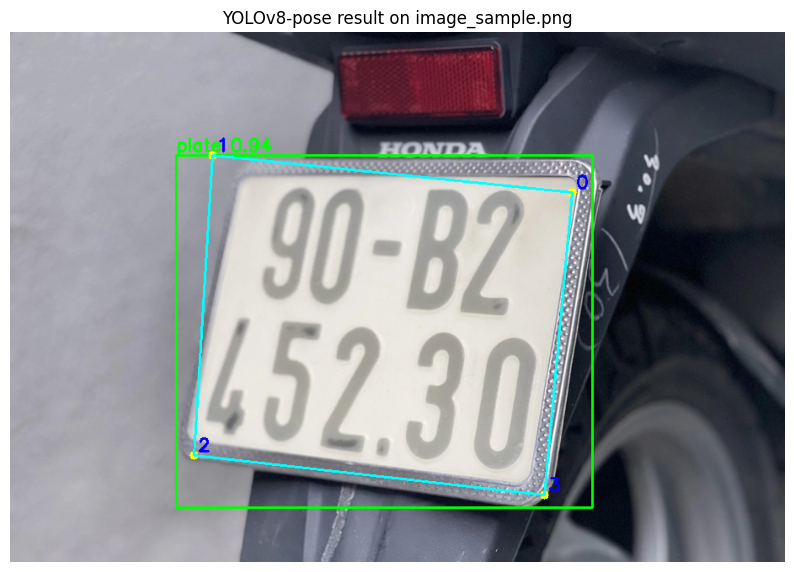

In [4]:
# Chạy model YOLOv8 lên ảnh image_sample.png và hiển thị kết quả với keypoint, bbox
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Đường dẫn model và ảnh (đổi lại nếu cần)
model_path = 'best_200.pt'  # hoặc best_50.pt, best_yolo.pt tuỳ bạn
img_path = 'image_sample2.png'

assert Path(model_path).exists(), f'Không tìm thấy model: {model_path}'
assert Path(img_path).exists(), f'Không tìm thấy ảnh: {img_path}'

model = YOLO(model_path)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = model(img, conf=0.25, iou=0.6, imgsz=640, max_det=5)
res = results[0]

def draw_pose(img, res, conf=0.25):
    img = img.copy()
    if hasattr(res, 'boxes') and res.boxes is not None:
        for idx, b in enumerate(res.boxes):
            c = float(b.conf[0]) if b.conf is not None else 0.0
            if c < conf: continue
            # Sửa lỗi: chuyển tensor sang numpy trước khi astype(int)
            xyxy = b.xyxy[0].cpu().numpy().astype(int) if hasattr(b.xyxy[0], 'cpu') else b.xyxy[0].astype(int)
            x1, y1, x2, y2 = xyxy
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(img, f'plate {c:.2f}', (x1, max(0, y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    if hasattr(res, 'keypoints') and res.keypoints is not None and hasattr(res.keypoints, 'xy'):
        kps_xy = res.keypoints.xy
        for pts in kps_xy:
            if pts.shape[0] >= 4:
                pts_np = pts.cpu().numpy() if hasattr(pts, 'cpu') else np.array(pts)
                for i, (px, py) in enumerate(pts_np[:4]):
                    cv2.circle(img, (int(px), int(py)), 5, (255,255,0), -1)
                    cv2.putText(img, str(i), (int(px)+5, int(py)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                cv2.polylines(img, [pts_np[:4].astype(int).reshape(-1,1,2)], True, (0,255,255), 2)
    return img

img_vis = draw_pose(img_rgb, res, conf=0.25)
plt.figure(figsize=(10,8))
plt.imshow(img_vis)
plt.axis('off')
plt.title('YOLOv8-pose result on image_sample.png')
plt.show()